C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


DB Index: 1.174210071675312


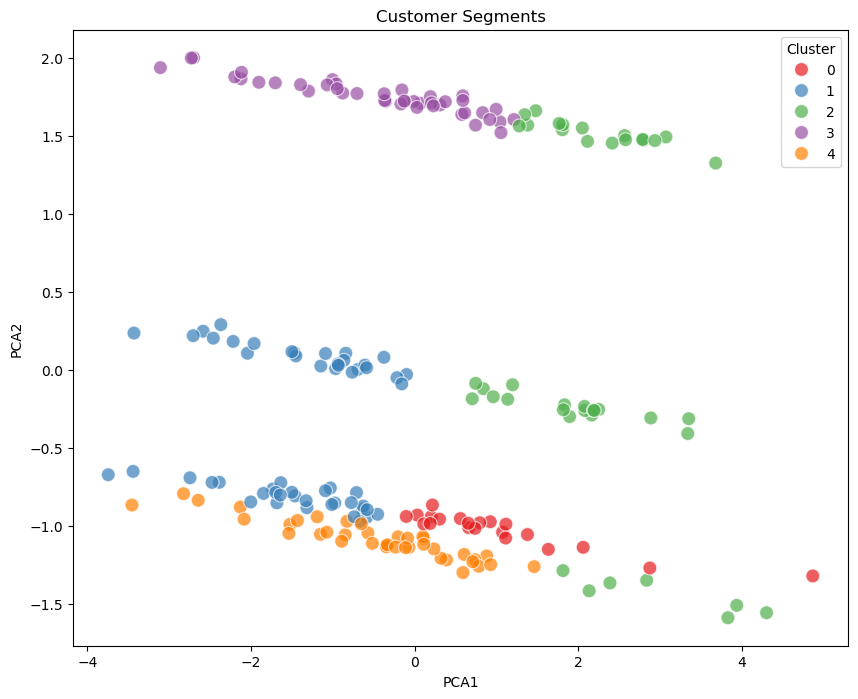

   Cluster   TotalSpend  PurchaseFrequency  TotalQuantity    AvgPrice
0        0  5048.289524           6.190476      16.904762  296.158445
1        1  2099.766364           3.400000       8.127273  264.359118
2        2  5748.217381           7.642857      20.690476  280.329917
3        3  2820.579524           4.357143      10.523810  264.025026
4        4  2784.740000           4.589744      10.871795  268.129303


In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge customers and transactions on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

# Feature Engineering
# Calculate total spend and frequency of purchases per customer
customer_transactions = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

customer_transactions.rename(columns={
    'TotalValue': 'TotalSpend',
    'TransactionID': 'PurchaseFrequency',
    'Quantity': 'TotalQuantity',
    'Price': 'AvgPrice'
}, inplace=True)

# Merge back with customer demographics
customer_data = pd.merge(customer_transactions, customers_df[['CustomerID', 'Region']], on='CustomerID')

# Handle categorical variable 'Region' using one-hot encoding
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop(['CustomerID'], axis=1))

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate the DB Index for cluster evaluation
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"DB Index: {db_index}")

# Reduce dimensionality to 2D for visualization using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(principal_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments')
plt.show()

# Cluster Profiling: Analyze each cluster
cluster_profiles = customer_data.groupby('Cluster').agg({
    'TotalSpend': 'mean',
    'PurchaseFrequency': 'mean',
    'TotalQuantity': 'mean',
    'AvgPrice': 'mean'
}).reset_index()

print(cluster_profiles)
